In [33]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from datetime import datetime as dt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree


In [34]:
features= pd.read_csv("cardio_train.csv",sep=';')
features=features.loc[:10000]
features.drop("id",axis=1,inplace=True)
target = features['cardio']
features = features.drop(['cardio'], axis=1)
target=target.to_numpy()
features=features.to_numpy()


In [35]:
def entropy(s):
    counts = np.bincount(s)
    percentages = counts / len(s)
    
    entropy = 0
    for pct in percentages:
        if pct > 0:
            entropy += pct * np.log2(pct)
    return -entropy

In [36]:
class Node:
    '''
    Helper class which implements a single tree node.
    '''
    def __init__(self, feature=None, threshold=None, data_left=None, data_right=None, gain=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.data_left = data_left
        self.data_right = data_right
        self.gain = gain
        self.value = value

In [37]:

class DecisionTree:
    '''
    Class which implements a decision tree classifier algorithm.
    '''
    def __init__(self, min_samples_split=2, max_depth=5):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None
        
    @staticmethod
    def entropy(s):
        '''
        Helper function, calculates entropy from an array of integer values.
        
        :param s: list
        :return: float, entropy value
        '''
        # Convert to integers to avoid runtime errors
        counts = np.bincount(np.array(s, dtype=np.int64))
        # Probabilities of each class label
        percentages = counts / len(s)

        # Caclulate entropy
        entropy = 0
        for pct in percentages:
            if pct > 0:
                entropy += pct * np.log2(pct)
        return -entropy
    
    def information_gain(self, parent, left_child, right_child):
        '''
        Helper function, calculates information gain from a parent and two child nodes.
        
        :param parent: list, the parent node
        :param left_child: list, left child of a parent
        :param right_child: list, right child of a parent
        :return: float, information gain
        '''
        num_left = len(left_child) / len(parent)
        num_right = len(right_child) / len(parent)
        
        # One-liner which implements the previously discussed formula
        return self.entropy(parent) - (num_left * self.entropy(left_child) + num_right * self.entropy(right_child))
    
    def best_split(self, X, y):
        '''
        Helper function, calculates the best split for given features and target
        
        :param X: np.array, features
        :param y: np.array or list, target
        :return: dict
        '''
        best_split = {}
        best_info_gain = -1
        n_rows, n_cols = X.shape
        
        # For every dataset feature
        for f_idx in range(n_cols):
            X_curr = X[:, f_idx]
            # For every unique value of that feature
            for threshold in np.unique(X_curr):
                # Construct a dataset and split it to the left and right parts
                # Left part includes records lower or equal to the threshold
                # Right part includes records higher than the threshold
                df = np.concatenate((X, y.reshape(1, -1).T), axis=1)
                df_left = np.array([row for row in df if row[f_idx] <= threshold])
                df_right = np.array([row for row in df if row[f_idx] > threshold])

                # Do the calculation only if there's data in both subsets
                if len(df_left) > 0 and len(df_right) > 0:
                    # Obtain the value of the target variable for subsets
                    y = df[:, -1]
                    y_left = df_left[:, -1]
                    y_right = df_right[:, -1]

                    # Caclulate the information gain and save the split parameters
                    # if the current split if better then the previous best
                    gain = self.information_gain(y, y_left, y_right)
                    if gain > best_info_gain:
                        best_split = {
                            'feature_index': f_idx,
                            'threshold': threshold,
                            'df_left': df_left,
                            'df_right': df_right,
                            'gain': gain
                        }
                        best_info_gain = gain
        return best_split
    
    def build(self, X, y, depth=0):
        '''
        Helper recursive function, used to build a decision tree from the input data.
        
        :param X: np.array, features
        :param y: np.array or list, target
        :param depth: current depth of a tree, used as a stopping criteria
        :return: Node
        '''
        n_rows, n_cols = X.shape
        
        # Check to see if a node should be leaf node
        if n_rows >= self.min_samples_split and depth <= self.max_depth:
            # Get the best split
            best = self.best_split(X, y)
            # If the split isn't pure
            if best['gain'] > 0:
                # Build a tree on the left
                left = self.build(
                    X=best['df_left'][:, :-1], 
                    y=best['df_left'][:, -1], 
                    depth=depth + 1
                )
                right = self.build(
                    X=best['df_right'][:, :-1], 
                    y=best['df_right'][:, -1], 
                    depth=depth + 1
                )
                return Node(
                    feature=best['feature_index'], 
                    threshold=best['threshold'], 
                    data_left=left, 
                    data_right=right, 
                    gain=best['gain']
                )
        # Leaf node - value is the most common target value 
        return Node(
            value=Counter(y).most_common(1)[0][0]
        )
    
    def fit(self, X, y):
        '''
        Function used to train a decision tree classifier model.
        
        :param X: np.array, features
        :param y: np.array or list, target
        :return: None
        '''
        # Call a recursive function to build the tree
        self.root = self.build(X, y)
        
    def _predict(self, x, tree):
        '''
        Helper recursive function, used to predict a single instance (tree traversal).
        
        :param x: single observation
        :param tree: built tree
        :return: float, predicted class
        '''
        # Leaf node
        if tree.value != None:
            return tree.value
        feature_value = x[tree.feature]
        
        # Go to the left
        if feature_value <= tree.threshold:
            return self._predict(x=x, tree=tree.data_left)
        
        # Go to the right
        if feature_value > tree.threshold:
            return self._predict(x=x, tree=tree.data_right)
        
    def predict(self, X):
        '''
        Function used to classify new instances.
        
        :param X: np.array, features
        :return: np.array, predicted classes
        '''
        # Call the _predict() function for every observation
        return [self._predict(x, self.root) for x in X]

In [38]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=0)
mytree_model = DecisionTree()
start = dt.now()
mytree_model.fit(X_train, y_train)
end = dt.now()
running_time = end - start
print("time for training of my tree is : ", running_time)

start = dt.now()
preds = mytree_model.predict(X_test)
end = dt.now()
running_time = end - start

print("time for prediction of my tree is : ", running_time)

Score=accuracy_score(y_test, preds)
print("my tree's score is : ", Score)


time for training of my tree is :  0:01:18.307957
time for prediction of my tree is :  0:00:00.011956
my tree's score is :  0.7180939686771076


In [39]:
print(mytree_model.root.feature)

4


In [40]:
sklearn_model = DecisionTreeClassifier(criterion='entropy')

start = dt.now()
sklearn_model.fit(X_train, y_train)
end = dt.now()
running_time = end - start
print("time for training of sklearn's tree is : ", running_time)

start = dt.now()
preds = sklearn_model.predict(X_test)
end = dt.now()
running_time = end - start

print("time for prediction of sklearn's tree is : ", running_time)

Score=accuracy_score(y_test, preds)
print("sklearn's tree score is : ", Score)

time for training of sklearn's tree is :  0:00:00.056592
time for prediction of sklearn's tree is :  0:00:00.002225
sklearn's tree score is :  0.6377874041986005


In [41]:
data= pd.read_csv("StudentGrades.csv",sep=';')
data

,Early registeration,Finished homework ll,Senior,Likes Coffee,Liked The Last homework,A
0,1,1,0,0,1,1
1,1,1,1,0,1,1
2,0,0,1,0,0,0
3,0,1,1,0,1,0
4,0,1,1,0,0,1
5,0,0,1,1,1,1
6,1,0,0,0,1,0
7,0,1,0,1,1,1
8,0,0,1,0,1,1
9,1,0,0,0,0,0


In [42]:
sklearn_model = DecisionTreeClassifier(criterion='entropy',random_state=1234)
X = data.iloc[:,:-1]
y = data['A']
X

,Early registeration,Finished homework ll,Senior,Likes Coffee,Liked The Last homework
0,1,1,0,0,1
1,1,1,1,0,1
2,0,0,1,0,0
3,0,1,1,0,1
4,0,1,1,0,0
5,0,0,1,1,1
6,1,0,0,0,1
7,0,1,0,1,1
8,0,0,1,0,1
9,1,0,0,0,0


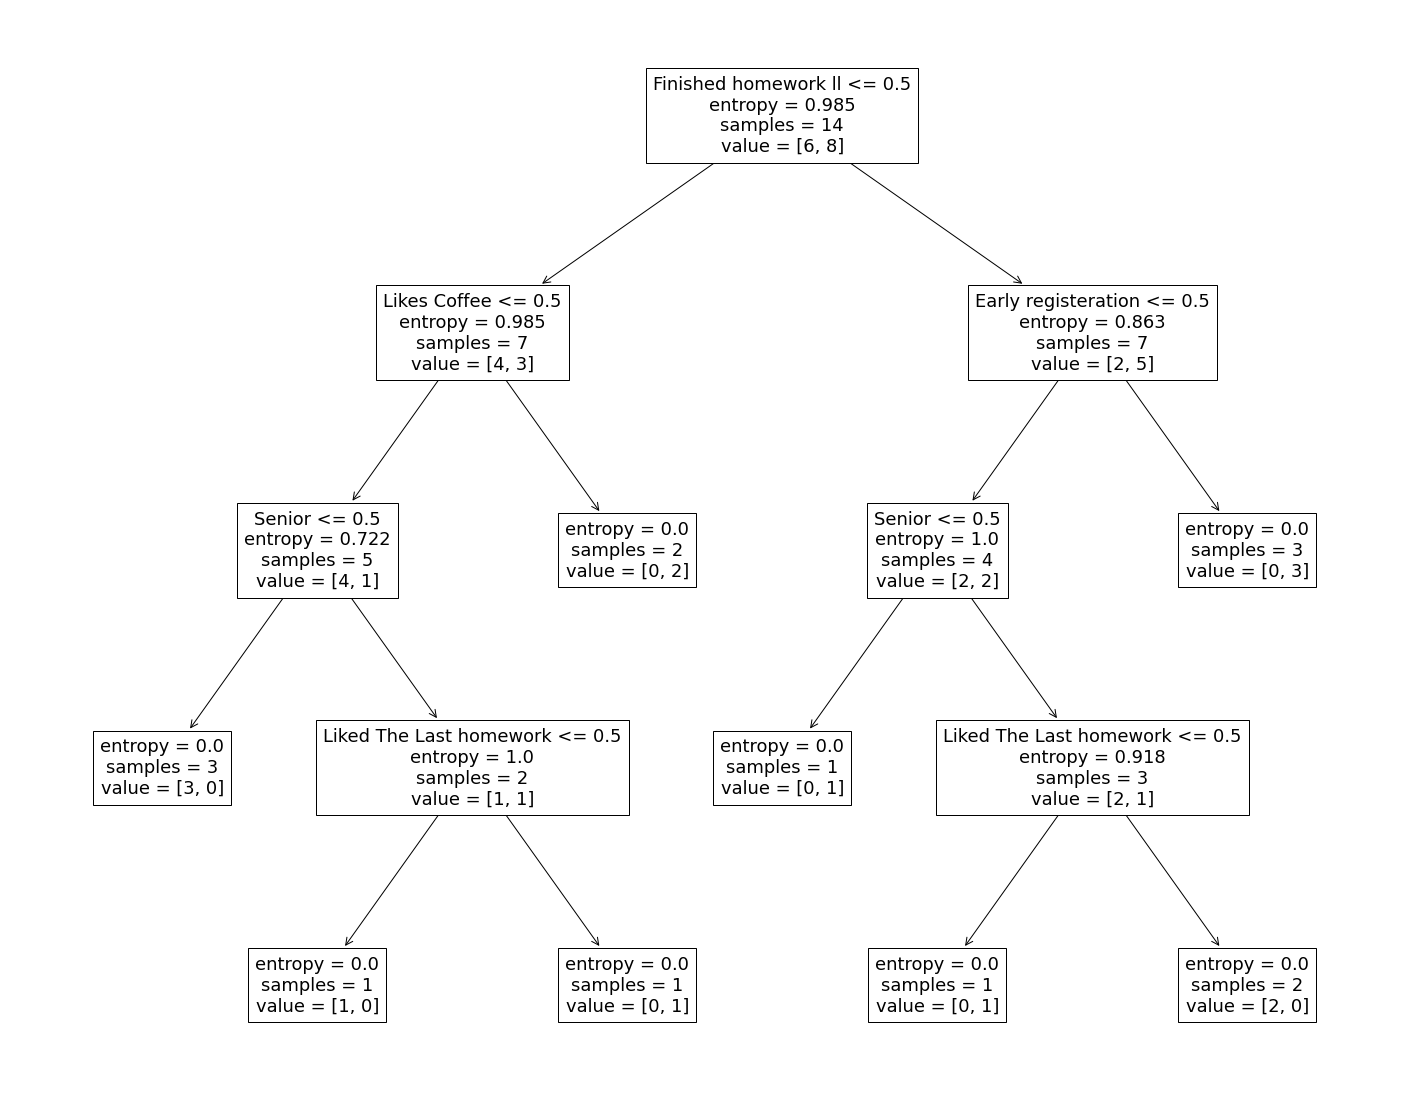

In [43]:
model = sklearn_model.fit(X, y)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(sklearn_model, 
                   feature_names=X.columns)

In [44]:
mytree_model = DecisionTree()
data=X.to_numpy()
target=y.to_numpy()
mytree_model.fit(data, target)

In [45]:
print(mytree_model.root.feature) #that is the finished HomeWork feature which is the root of the tree

1


In [46]:
print(mytree_model.root.gain)

0.06105378373381021
